# **SONG RECOMMENDER SYSTEM**
---
**Kelompok 8 (Intern Data Science BCC 2023):**

* **Amira Ghina Nurfansepta**

* **Diyang Raditya Anwar**

# Dataset [Kaggle](https://www.kaggle.com/datasets/anuragbanerjee/million-song-data-set-subset)
Dataset ini berisi 2 file, yang terdiri dari file csv untuk informasi lagu dan file txt untuk informasi pengguna. Dataset ini memuat pengetahuan dasar dari lagu, seperti id lagu, judul lagu, penyanyinya, serta memuat id pengguna, dan juga seberapa sering pengguna mendengarkan suatu lagu atau preferensi pengguna.

# Data Understanding
Data Understanding merupakan tahap awal dari proses Data Science. Tujuan dari tahap ini adalah mengumpulkan informasi tentang data yang akan dianalisis. Pada tahap ini, data akan dideskripsikan, dilakukan statistika deskriptif, dan diuji kualitasnya untuk eksplorasi data sehingga dapat mengungkapkan pola dan hubungan yang menarik.

## Import Library

In [1]:
import numpy as np
import pandas as pd
import time

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, norm, probplot
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from scipy import *
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
import operator
import math as mt
from scipy.sparse import *
from scipy.sparse.linalg import *
from lightfm import LightFM

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Dataset

In [2]:
df_track = pd.read_csv('D:\BCC\song_data.csv')
df_track.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [3]:
df_user = pd.read_csv(r'D:\BCC\user_data.txt', sep='\t', header=None, names=['user_id','song_id','listen_count'])
df_user.head()

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


## Informasi Mengenai Dataset

### Jumlah Baris dan Kolom Dataset

In [4]:
print("Shape df_track =", df_track.shape)
print("Shape df_user =", df_user.shape)

Shape df_track = (1000000, 5)
Shape df_user = (2000000, 3)


Kedua dataset, baik df_track dan df_user memiliki jumlah baris yang sangat banyak dan kolom yang cukup sedikit.

### Informasi Dataset

In [5]:
df_track.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999985 non-null   object
 2   release      999995 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38.1+ MB


In [6]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   song_id       object
 2   listen_count  int64 
dtypes: int64(1), object(2)
memory usage: 45.8+ MB


df_track memiliki 4 kolom yang bertipe object dan 1 kolom yang bertipe integer, sedangkan df_user memiliki 3 kolom yang bertipe object dan 1 kolom yang bertipe integer.

### Statistika Deskriptif Dataset

In [7]:
df_track.describe()

,year
count,1000000.000000
mean,1030.325652
std,998.745002
min,0.000000
25%,0.000000
50%,1969.000000
75%,2002.000000
max,2011.000000


In [8]:
df_track[['song_id', 'title', 'release', 'artist_name']].describe()

,song_id,title,release,artist_name
count,1000000,999985,999995,1000000
unique,999056,702428,149288,72665
top,SOUYQYY12AF72A000F,Intro,Greatest Hits,Michael Jackson
freq,3,1510,2014,194


In [9]:
df_user.describe()

,listen_count
count,2.000000e+06
mean,3.045485e+00
std,6.579720e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,2.213000e+03


In [10]:
df_user[['user_id', 'song_id']].describe()

,user_id,song_id
count,2000000,2000000
unique,76353,10000
top,6d625c6557df84b60d90426c0116138b617b9449,SOFRQTD12A81C233C0
freq,711,8277


* Terdapat pengguna yang terobsesi dengan sebuah lagu hingga mendengarkannya sebanyak 2213
* Jumlah pengguna adalah 76353 dan jumlah lagu yang didengarkan hanya 10000 sehingga tidak semua lagu yang berada di dalam dataset didengarkan oleh pengguna.

### Cek Kolom Kosong


In [11]:
df_track[df_track['year'] == 0].count()

song_id        484424
title          484409
release        484419
artist_name    484424
year           484424
dtype: int64

In [12]:
df_track.isna().sum()

song_id         0
title          15
release         5
artist_name     0
year            0
dtype: int64

In [13]:
df_user.isna().sum()

user_id         0
song_id         0
listen_count    0
dtype: int64

* Terdapat 484424 baris pada df_track yang kolom year-nya berisi 0 sehingga kolom perlu dihapus karena hampir setengah dari track tidak diketahui tahun rilisnya.
* Terdapat 2 kolom pada df_track yang memiliki missing values, sedangkan df_user tidak memiliki missing values.

### Cek Data Duplikat

In [14]:
print("Jumlah data duplikat pada df_track:", df_track.duplicated().sum())
print("Jumlah data duplikat pada df_user:", df_user.duplicated().sum())

Jumlah data duplikat pada df_track: 498
Jumlah data duplikat pada df_user: 0


In [15]:
df_track['song_id'].nunique()

999056

In [16]:
df_track[['title', 'artist_name']].duplicated().sum()

73904

* Terdapat 498 data duplikat pada df_track, sedangkan tidak terdapat data duplikat pada df_user.
* Jumlah song_id yang unik adalah 999036 sehingga terdapat beberapa song_id yang duplikat.
* Terdapat lagu yang duplikat walau dengan song_id yang berbeda.

# Data Preprocessing
Data preprocessing adalah tahap berikutnya dalam proses Data Science. Pada tahap ini, data akan diubah, data yang hilang diisi, data disederhanakan, data disamakan, dan lain sebagainya. Tujuan akhir dari tahap ini adalah untuk mengubah data menjadi sebuah bentuk yang dapat dianalisis dengan mudah.

## Menghapus Kolom Year

In [17]:
df_track = df_track.drop('year', axis=1)
df_track.head()

,song_id,title,release,artist_name
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic


## Menghapus Data yang Memiliki Missing Values

In [18]:
df_track = df_track.dropna()
df_track.isna().sum()

song_id        0
title          0
release        0
artist_name    0
dtype: int64

## Menghapus Data Duplikat

In [19]:
df_track = df_track.drop_duplicates(keep='first')
df_track.duplicated().sum()

0

In [20]:
df_track = df_track.drop_duplicates(subset='song_id').reset_index(drop=True)
df_track['song_id'].duplicated().sum()

0

In [21]:
df_track = df_track.drop_duplicates(subset=['title', 'artist_name']).reset_index(drop=True)
df_track.head()

,song_id,title,release,artist_name
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic


## Merge Dataset

In [22]:
df_merge = pd.merge(df_user, df_track,
                    how='left', 
                    left_on='song_id', 
                    right_on='song_id')
df_merge.head()

,user_id,song_id,listen_count,title,release,artist_name
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,NaN,NaN,NaN
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters


## Menghapus Data yang Memiliki Missing Values pada Dataset Merge 

In [23]:
df_merge.isna().sum()

user_id              0
song_id              0
listen_count         0
title           281017
release         281017
artist_name     281017
dtype: int64

In [24]:
df_merge = df_merge.dropna()
df_merge.isna().sum()

user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
dtype: int64

In [25]:
df_merge.head()

,user_id,song_id,listen_count,title,release,artist_name
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5,Apuesta Por El Rock 'N' Roll,Antología Audiovisual,Héroes del Silencio


# Exploratory Data Analysis
Exploratory Data Analysis atau yang biasa disingkat dengan EDA merupakan proses yang untuk mengeksplorasi data dan mencari pola dan hubungan yang mungkin tidak diketahui sebelumnya. Metode EDA berfokus pada eksplorasi visual dan menggunakan statistik deskriptif untuk mengidentifikasi pola dan hubungan dalam data.

## Apa album yang memiliki paling banyak lagu pada dataset?

In [26]:
df_release = df_track['release'].value_counts(ascending=False).reset_index()
df_release.columns = ['release', 'count']
df_release.head()

,release,count
0,Greatest Hits,1734
1,Live,998
2,The Collection,727
3,The Ultimate Collection,722
4,The Very Best Of,630


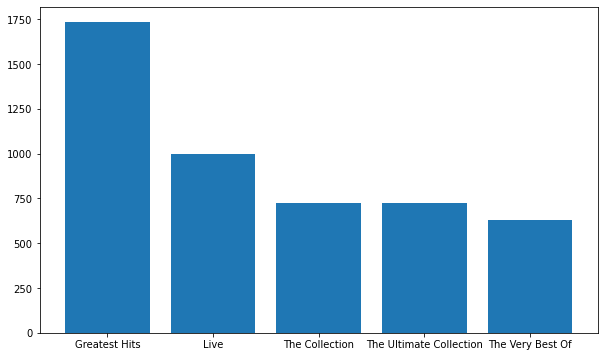

In [27]:
df_release_head = df_release.head()
plt.figure(figsize = (10,6))
plt.bar(df_release_head['release'], df_release_head['count'])
plt.show()

In [28]:
df_track[df_track['release'] == 'Greatest Hits'].head()

,song_id,title,release,artist_name
1771,SOPKQJR12AB0187C6B,Jailhouse Rock,Greatest Hits,The Jordanaires
2531,SOAUWOW12A58A7BE4F,Helen's Testimony (LP Version),Greatest Hits,Helen Baylor
3045,SOJPMXC12A58A7C2BA,Blessed,Greatest Hits,Martina McBride
3474,SOYPIJZ12D021B4C1D,We Used To,Greatest Hits,Dolly Parton
4020,SOTMBJI12AB0185A2B,It's Only Make Believe,Greatest Hits,Screamin' Jay Hawkins


In [29]:
df_track[df_track['release'] == 'Live'].head()

,song_id,title,release,artist_name
258,SOCQXCS12A67ADA4EA,Telegram för en tennsoldat,Live,Cornelis Vreeswijk
471,SONFGYH12AF72A0C0B,Holdin' On To Yesterday,Live,Ambrosia
770,SOBWFYH12A58A79F4C,Chicken (Live),Live,Mississippi John Hurt
1145,SOOFOXZ12AB018A13E,Perfect Goodbye,Live,Heart
1900,SOFASTD12A8C139AB6,La Fille D'Avril,Live,Laurent Voulzy


Album yang memiliki paling banyak lagu pada dataset ternyata bukanlah album milik artis perseorangan, tetapi berupa album kompilasi dari berbagai artis.

## Siapa artis yang memiliki paling banyak lagu pada dataset?

In [30]:
df_artist = df_track['artist_name'].value_counts(ascending=False).reset_index()
df_artist.columns = ['artist_name', 'count']
df_artist.head()

,artist_name,count
0,Beastie Boys,177
1,Joan Baez,175
2,The Doors,167
3,Johnny Cash,164
4,Duran Duran,157


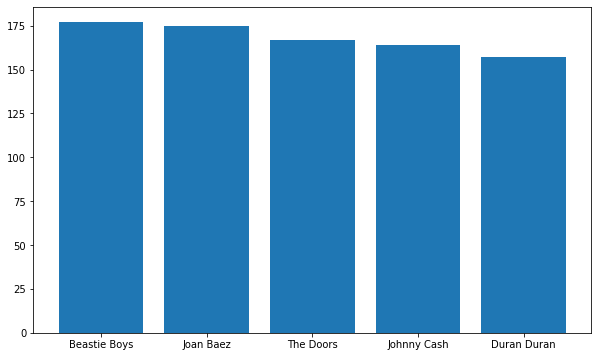

In [31]:
df_artist_head = df_artist.head()
plt.figure(figsize = (10,6))
plt.bar(df_artist_head['artist_name'], df_artist_head['count'])
plt.show()

5 artis teratas yang memiliki lagu paling banyak dalam dataset masing-masing merupakan penyanyi dengan genre yang berbeda-beda.
* Beastie Boys: Hip Hop
* Joan Baez : Folk
* The Doors : Rock 
* Johnny Cash : Country
* Duran Duran : Electronic Pop Rock

## Apa kata-kata yang sering muncul pada judul lagu?

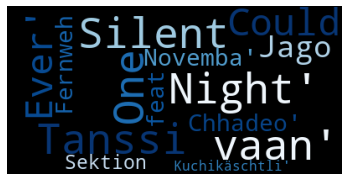

In [32]:
eng_stopwords = stopwords.words('english')
text = df_track['title'].values 
wordcloud = WordCloud(background_color='black', stopwords=eng_stopwords, colormap='Blues', max_font_size=50, max_words=50).generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [33]:
df_track_silent = df_track[df_track['title'].str.contains('Silent')]
print("Jumlah lagu yang memiliki kata silent =", df_track_silent.shape[0])
df_track_silent.head()

Jumlah lagu yang memiliki kata silent = 769


,song_id,title,release,artist_name
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat
49,SOCWWYB12A6D4F9AF4,He Is Not Silent (Out Of The Grey Album Version),The Early Years,Out Of The Grey
1258,SORXFJS12AB0180C00,Silent Night (Long Version) (2009 Digital Rema...,I Do Not Want What I Haven't Got (Special Edit...,Sinéad O'Connor
1263,SOHPWWO12AB017D84D,Halcyon: The Heavy Silence: In Silent Rain,Cypher,& And Oceans
1869,SOFKVBT12A58A79B2C,Silent Tunes Of Falling Blood,Shadows' Blood,Cultus Sanguine


In [34]:
df_artist_silent = df_track_silent['artist_name'].value_counts(ascending=False).reset_index()
df_artist_silent.columns = ['artist_name', 'count']
df_artist_silent.head()

,artist_name,count
0,Catherine Howe,12
1,Jeff And Sheri Easter,6
2,Swayzak,5
3,Stephen Varcoe/Choir of King's College_ Cambri...,4
4,Halford,4


In [35]:
df_track_silent[df_track_silent['artist_name'] == "Catherine Howe"]

,song_id,title,release,artist_name
173555,SOFVYEY12AB01803A4,What Are Friends For Anyway (From Silent Mothe...,Harry / Silent Mother Nature,Catherine Howe
218638,SOQKZLZ12AB017E221,It Took My Breath Away (From Silent Mother Nat...,Harry / Silent Mother Nature,Catherine Howe
227410,SOHKCHB12AB0181FE3,Callous Young Man (From Silent Mother Nature),Harry / Silent Mother Nature,Catherine Howe
380503,SOBYDZK12AB017E277,Silent Mother Nature (From Silent Mother Nature),Harry / Silent Mother Nature,Catherine Howe
393392,SOGIZHJ12A58A7A96D,Crumbs On The Table (From Silent Mother Nature),Harry / Silent Mother Nature,Catherine Howe
421703,SOGGYSM12A58A79111,Freedom Enough (From Silent Mother Nature),Harry / Silent Mother Nature,Catherine Howe
544846,SOBVDQM12AB0180385,Just Supposing (From Silent Mother Nature),Harry / Silent Mother Nature,Catherine Howe
576610,SOAORSL12A58A7CE57,You Make Me (From Silent Mother Nature),Harry / Silent Mother Nature,Catherine Howe
724235,SOKMMKS12A58A78102,The Devil's Driving Me (From Silent Mother Nat...,Harry / Silent Mother Nature,Catherine Howe
782122,SORZXUE12AB017DFE9,Keep Me Talking (From Silent Mother Nature),Harry / Silent Mother Nature,Catherine Howe


In [36]:
df_track_silent[df_track_silent['artist_name'] == "Jeff And Sheri Easter"]

,song_id,title,release,artist_name
15565,SOWHDLQ12A58A7BE59,We Need Hope (Silent Witness Album Version),Silent Witness,Jeff And Sheri Easter
162966,SOQFMCQ12A6D4F810E,Let The Little Things Go (Silent Witness Album...,Silent Witness,Jeff And Sheri Easter
292575,SOUGUBP12A6D4F810F,Hope For The Hopeless (Silent Witness Album Ve...,Silent Witness,Jeff And Sheri Easter
437019,SOKCIGV12A6D4F810B,A Love That Keeps On Giving (Silent Witness Al...,Silent Witness,Jeff And Sheri Easter
516390,SOSPUYN12A6D4F810D,In God's Hands (Silent Witness Album Version),Silent Witness,Jeff And Sheri Easter
909408,SOXCYKL12A58A7D8F0,Don't Let Cain Kill Abel (Silent Witness Album...,Silent Witness,Jeff And Sheri Easter


In [37]:
df_track_silent[df_track_silent['artist_name'] == "Swayzak"]

,song_id,title,release,artist_name
144776,SONCUHG12A8C138332,Silent Luv (Andre Kurbel Remix),Silent Luv,Swayzak
338362,SOLLSVJ12A8C138334,Silent Luv (Anomy Remix),Silent Luv,Swayzak
753711,SOBJKPG12A8C138336,Silent Luv (David Jay Dub'it Mix),Silent Luv,Swayzak
804083,SOIQGFQ12A8C132491,Silent Luv,Silent Luv,Swayzak
811644,SOLHVCB12A8C13832E,Silent Luv (Bruns Silent Dubh),Silent Luv,Swayzak


* Kata terbanyak yang muncul dalam judul lagu pada dataset adalah "Silent".
* Berdasarkan 3 penyanyi teratas yang menggunakan kata "Silent" dalam judul lagunya, judul lagu yang dimiliki ternyata mengandung nama albumnya sehingga setiap lagu yang ada di dalam album itu memiliki kata "Silent" di dalam judul lagunya. Selain mengandung nama album, terdapat penyanyi yang lagunya di-remix oleh beberapa orang sehingga judul lagunya berulang dengan remix yang berbeda-beda.

## Apa lagu yang membuat pengguna terobsesi?

In [38]:
df_merge['listen_count'].describe().reset_index().T

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
listen_count,1718983.0,3.050911,6.635798,1.0,1.0,1.0,3.0,2213.0


In [39]:
df_obsessed = df_merge[df_merge['listen_count'] >= 500].sort_values('listen_count', ascending=False)
percentage = df_obsessed.shape[0]/df_merge.shape[0] * 100
print("Pengguna yang mendengarkan suatu lagu lebih dari 500 kali adalah {:.3%}".format(percentage))
df_obsessed

Pengguna yang mendengarkan suatu lagu lebih dari 500 kali adalah 0.064%


,user_id,song_id,listen_count,title,release,artist_name
1228366,d13609d62db6df876d3cc388225478618bb7b912,SOFCGSE12AF72A674F,2213,Starshine,Gorillaz,Gorillaz
1586780,5ea608df0357ec4fda191cb9316fe8e6e65e3777,SOKOSPK12A8C13C088,879,Call It Off (Album Version),The Con,Tegan And Sara
31179,bb85bb79612e5373ac714fcd4469cabeb5ed94e1,SOZQSVB12A8C13C271,796,Paradise & Dreams,Skydivin',Darren Styles
1875121,c012ec364329bb08cbe3e62fe76db31f8c5d8ec3,SOBONKR12A58A7A7E0,683,You're The One,If There Was A Way,Dwight Yoakam
1644909,70caceccaa745b6f7bc2898a154538eb1ada4d5a,SOPREHY12AB01815F9,676,I'm On A Boat,Incredibad,The Lonely Island / T-Pain
1374693,d2232ac7a1ec17b283b5dff243161902b2cb706c,SOLGIWB12A58A77A05,649,Reelin' In The Years,The Definitive Collection,Steely Dan
1819571,f5363481018dc87e8b06f9451e99804610a594fa,SOVRIPE12A6D4FEA19,605,Can't Help But Wait (Album Version),Kiss Presents The Mixtape,Trey Songz
515442,f1bdbb9fb7399b402a09fa124210dedf78e76034,SOZPMJT12AAF3B40D1,585,The Quest,A Taste Of Extreme Divinity,HYPOCRISY
1644901,70caceccaa745b6f7bc2898a154538eb1ada4d5a,SOJCRUY12A67ADA4C2,553,Fast Car (LP Version),Tracy Chapman,Tracy Chapman
1578918,2be4e2736f580dd4fe7b489f675935ccfad0a453,SOXBCZH12A67ADAD77,500,Peace Train,On The Road To Find Out (Repackaged),Cat Stevens


In [40]:
for i in range(df_obsessed.shape[0]):
  day = df_obsessed['listen_count'].iloc[i] * 3.5 / 60 / 24
  print("Pengguna mendengarkan lagu", df_obsessed['title'].iloc[i], "sebanyak", day, "hari")

Pengguna mendengarkan lagu Starshine sebanyak 5.378819444444445 hari
Pengguna mendengarkan lagu Call It Off (Album Version) sebanyak 2.136458333333333 hari
Pengguna mendengarkan lagu Paradise & Dreams sebanyak 1.934722222222222 hari
Pengguna mendengarkan lagu You're The One sebanyak 1.6600694444444446 hari
Pengguna mendengarkan lagu I'm On A Boat sebanyak 1.6430555555555555 hari
Pengguna mendengarkan lagu Reelin' In The Years sebanyak 1.5774305555555557 hari
Pengguna mendengarkan lagu Can't Help But Wait (Album Version) sebanyak 1.470486111111111 hari
Pengguna mendengarkan lagu The Quest sebanyak 1.421875 hari
Pengguna mendengarkan lagu Fast Car (LP Version) sebanyak 1.3440972222222223 hari
Pengguna mendengarkan lagu Peace Train sebanyak 1.215277777777778 hari
Pengguna mendengarkan lagu Glamorous sebanyak 1.215277777777778 hari


* Terdapat pengguna yang terobsesi dengan suatu lagu hingga 2213 kali memutarnya, padahal pada kuartil 3 (75%) hanya memutar 3 kali.
* Terdapat 11 pengguna yang mendengarkan suatu lagu lebih dari 500 kali dengan persentase 0.064% dari keseluruhan data yang ada.
* Dengan asumsi durasi setiap lagu selama 3.30 menit, pengguna yang paling terobsesi atau yang mendengarkan suatu lagu paling banyak mendengarkan lagu tersebut selama 5.38 hari.

## Berapa macam lagu yang diputar oleh pengguna?

In [41]:
print("Lagu yang didengarkan pengguna =", df_merge['song_id'].nunique())

Lagu yang didengarkan pengguna = 8841


In [42]:
df_users = df_merge['user_id'].value_counts(ascending=False).reset_index()
df_users.columns = ['user_id', 'song_count']
df_users.head()

,user_id,song_count
0,6d625c6557df84b60d90426c0116138b617b9449,617
1,fbee1c8ce1a346fa07d2ef648cec81117438b91f,552
2,24b98f8ab023f6e7a1c37c7729c623f7b821eb95,515
3,4e11f45d732f4861772b2906f81a7d384552ad12,507
4,15eeb36ae1c62d60de9fdeea0d121eb7d08713be,497


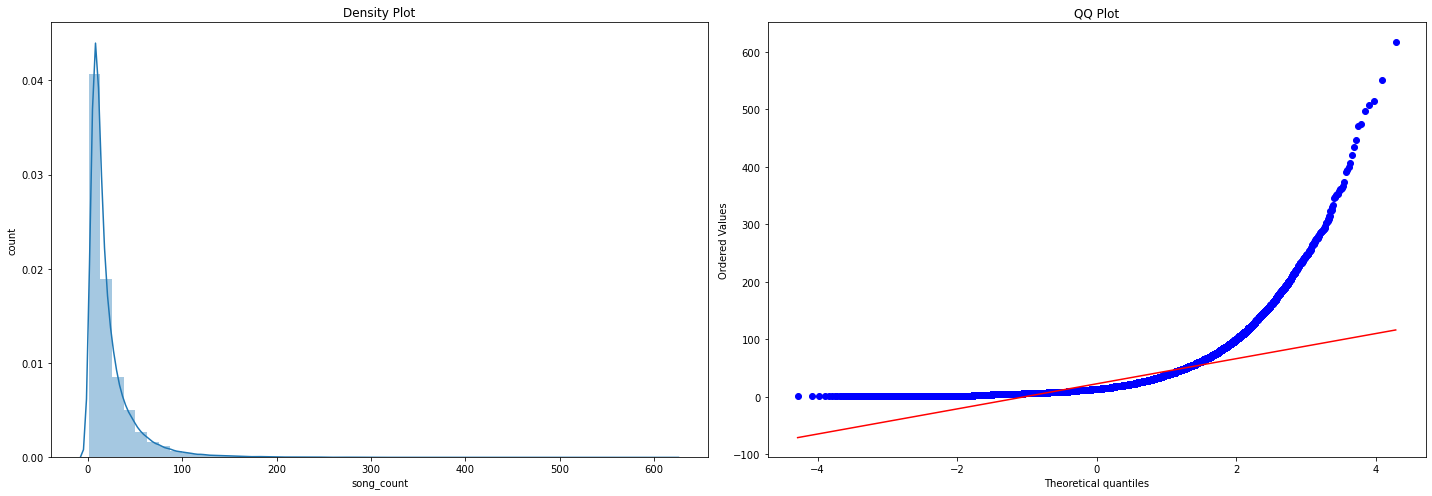

In [43]:
fig = plt.figure(figsize=(20,7))

f1 = fig.add_subplot(121)
sns.distplot(df_users['song_count'])
f1.set_title('Density Plot')
f1.set_xlabel('song_count')
f1.set_ylabel('count')

f2 = fig.add_subplot(122)
res = probplot(df_users['song_count'], plot=f2)
f2.set_title('QQ Plot')

plt.tight_layout()
plt.show()

Density plot adalah grafik yang menggambarkan distribusi data menggunakan kurva kontinu. Grafik ini umumnya digunakan untuk menilai kompleksitas distribusi data dan dapat digunakan untuk membandingkan beberapa set data. Kurva pada density plot dihasilkan dengan menghitung jumlah titik data yang berada dalam jangkauan tertentu dan membaginya dengan luas area dalam jangkauan tersebut. Sementara, QQ plot atau Quantile-Quantile plot adalah sebuah grafik yang digunakan untuk menguji kesamaan distribusi antara dua sampel data. QQ plot menggambarkan titik-titik data dari dua distribusi yang dibandingkan, sehingga memudahkan untuk menentukan apakah dua distribusi tersebut mirip atau tidak. QQ plot biasanya digunakan untuk membandingkan data dengan distribusi normal.

In [44]:
print("Mean =", df_users['song_count'].mean())
print("Standar Deviasi =", df_users['song_count'].std())
print("Skewness =", df_users['song_count'].skew())
print("Kurtosis =", df_users['song_count'].kurt())

Mean = 22.565939403486663
Standar Deviasi = 27.606344021106032
Skewness = 4.300215672392979
Kurtosis = 33.8638481122249


Skewness dalam distribusi normal adalah nol. Skewness mengukur ketidaksimetrian dari distribusi data. Dalam distribusi normal, titik tengah, median, dan mean sama, sehingga tidak ada ketidaksimetrian, atau skewness, yang terdeteksi. Sementara, kurtosis adalah istilah statistik yang mengukur tingkat kekerasan suatu distribusi data. Kurtosis dicirikan oleh puncak yang lebih tinggi dari distribusi normal. Kurtosis memiliki berbagai kegunaan, termasuk membantu dalam membandingkan distribusi data dengan distribusi normal.

In [45]:
outlier = []
def iqr_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    for i in df:
        if i > upper or i < lower:
            outlier.append(i)
    print("Outliers:", outlier)
    print("Jumlah data outliers =", len(outlier))
iqr_outliers(df_users['song_count'])

Outliers: [617, 552, 515, 507, 497, 474, 472, 447, 434, 420, 407, 400, 395, 391, 373, 367, 363, 362, 362, 358, 352, 352, 351, 348, 347, 345, 333, 330, 325, 323, 323, 315, 315, 310, 309, 305, 304, 302, 302, 297, 294, 294, 292, 292, 290, 290, 288, 288, 287, 286, 286, 285, 285, 282, 281, 279, 279, 277, 277, 276, 276, 275, 274, 274, 274, 273, 271, 270, 270, 268, 265, 265, 265, 265, 265, 264, 264, 262, 262, 258, 258, 257, 256, 255, 255, 254, 254, 253, 253, 252, 252, 249, 249, 249, 249, 248, 248, 248, 247, 247, 246, 246, 245, 245, 245, 244, 244, 244, 243, 242, 242, 242, 242, 241, 239, 239, 238, 238, 238, 237, 237, 237, 236, 236, 236, 235, 233, 233, 233, 233, 233, 233, 233, 232, 232, 232, 231, 231, 231, 230, 229, 228, 228, 228, 227, 227, 227, 226, 226, 225, 224, 224, 223, 223, 222, 222, 222, 222, 221, 221, 221, 221, 220, 220, 220, 219, 219, 218, 217, 216, 216, 216, 216, 216, 216, 216, 215, 215, 215, 215, 214, 214, 214, 214, 213, 213, 212, 211, 211, 211, 210, 210, 210, 210, 209, 209, 208, 208,

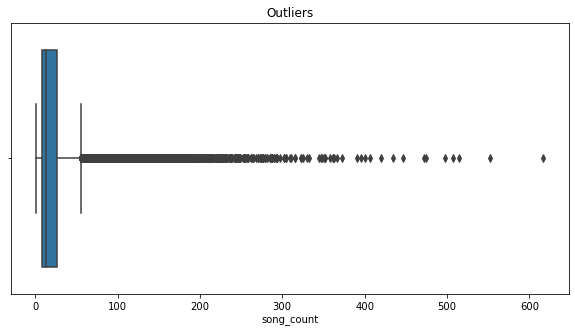

In [46]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(df_users['song_count'])
plt.title('Outliers')
plt.xlabel('song_count')
plt.show()

* Total hanya 8841 macam lagu yang diputar oleh semua pengguna dari keseluruhan lagu di dataset.
* Pengguna paling banyak memutar 617 macam lagu.
* Pengguna kebanyakan memutar macam lagu dalam range 1 hingga 25.
* Data tidak terdistribusi normal karena puncaknya lebih tinggi dari distribusi normal.
* Berdasarkan nilai skewness yang positif, data terdistorsi ke kanan. Seperti yang dapat dilihat pada grafik, data mempunyai ekor panjang ke arah kanan. Data terdistorsi adalah data yang telah mengalami distorsi, yaitu berubah menjadi bentuk yang berbeda dari asalnya. Data terdistorsi ke kanan adalah data yang telah mengalami distorsi ke arah yang lebih tinggi.
* Berdasarkan nilai kurtosis yang positif, distribusi data adalah heavy-tailed, yaitu data mempunyai outliers.
* Pengguna rata-rata memutar 23 macam lagu.
* Jumlah data outliers adalah 6317.

## Berapa kali pengguna mendengarkan lagu?

In [47]:
df_listen = df_merge.groupby(['user_id'])['listen_count'].sum().sort_values(ascending=False).reset_index()
df_listen.head()

,user_id,listen_count
0,4be305e02f4e72dad1b8ac78e630403543bab994,3719
1,6d625c6557df84b60d90426c0116138b617b9449,3155
2,d13609d62db6df876d3cc388225478618bb7b912,2630
3,0b19fe0fad7ca85693846f7dad047c449784647e,2301
4,5ea608df0357ec4fda191cb9316fe8e6e65e3777,2001


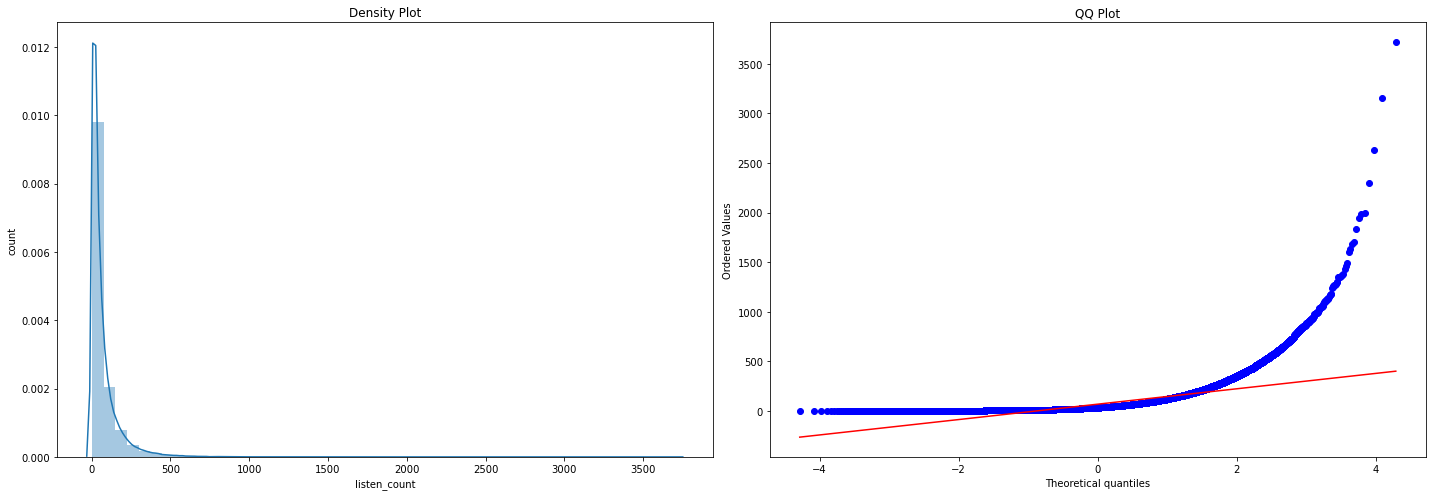

In [48]:
fig = plt.figure(figsize=(20,7))

f1 = fig.add_subplot(121)
sns.distplot(df_listen['listen_count'])
f1.set_title('Density Plot')
f1.set_xlabel('listen_count')
f1.set_ylabel('count')

f2 = fig.add_subplot(122)
res = probplot(df_listen['listen_count'], plot=f2)
f2.set_title('QQ Plot')

plt.tight_layout()
plt.show()

In [49]:
print("Mean =", df_listen['listen_count'].mean())
print("Standar Deviasi =", df_listen['listen_count'].std())
print("Skewness =", df_listen['listen_count'].skew())
print("Kurtosis =", df_listen['listen_count'].kurt())

Mean = 68.84667086746482
Standar Deviasi = 101.17903345799446
Skewness = 5.38576687072644
Kurtosis = 72.50290093448179


In [50]:
iqr_outliers(df_listen['listen_count'])

Outliers: [617, 552, 515, 507, 497, 474, 472, 447, 434, 420, 407, 400, 395, 391, 373, 367, 363, 362, 362, 358, 352, 352, 351, 348, 347, 345, 333, 330, 325, 323, 323, 315, 315, 310, 309, 305, 304, 302, 302, 297, 294, 294, 292, 292, 290, 290, 288, 288, 287, 286, 286, 285, 285, 282, 281, 279, 279, 277, 277, 276, 276, 275, 274, 274, 274, 273, 271, 270, 270, 268, 265, 265, 265, 265, 265, 264, 264, 262, 262, 258, 258, 257, 256, 255, 255, 254, 254, 253, 253, 252, 252, 249, 249, 249, 249, 248, 248, 248, 247, 247, 246, 246, 245, 245, 245, 244, 244, 244, 243, 242, 242, 242, 242, 241, 239, 239, 238, 238, 238, 237, 237, 237, 236, 236, 236, 235, 233, 233, 233, 233, 233, 233, 233, 232, 232, 232, 231, 231, 231, 230, 229, 228, 228, 228, 227, 227, 227, 226, 226, 225, 224, 224, 223, 223, 222, 222, 222, 222, 221, 221, 221, 221, 220, 220, 220, 219, 219, 218, 217, 216, 216, 216, 216, 216, 216, 216, 215, 215, 215, 215, 214, 214, 214, 214, 213, 213, 212, 211, 211, 211, 210, 210, 210, 210, 209, 209, 208, 208,

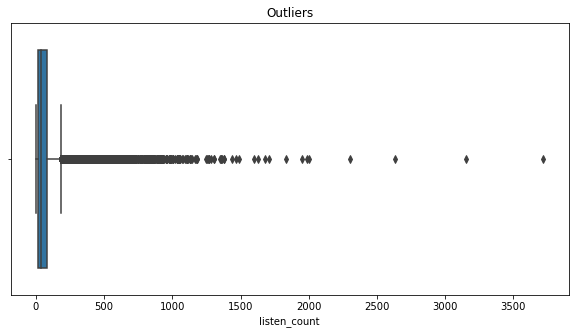

In [51]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(df_listen['listen_count'])
plt.title('Outliers')
plt.xlabel('listen_count')
plt.show()

* Pengguna paling banyak memutar lagu sebanyak 3719 lagu.
* Pengguna kebanyakan memutar lagu dalam range 1 hingga 100.
* Data tidak terdistribusi normal karena puncaknya lebih tinggi dari distribusi normal.
* Berdasarkan nilai skewness yang positif, data terdistorsi ke kanan. Seperti yang dapat dilihat pada grafik, data mempunyai ekor panjang ke arah kanan. Data terdistorsi adalah data yang telah mengalami distorsi, yaitu berubah menjadi bentuk yang berbeda dari asalnya. Data terdistorsi ke kanan adalah data yang telah mengalami distorsi ke arah yang lebih tinggi.
* Berdasarkan nilai kurtosis yang positif, distribusi data adalah heavy-tailed, yaitu data mempunyai outliers.
* Pengguna rata-rata memutar lagu sebanyak 69 kali.
* Jumlah data outliers adalah 12924.

Rekomendasi tidak perlu menggunakan distribusi normal. Distribusi normal dapat mengurangi akurasi hasil rekomendasi karena membatasi jenis data yang dapat digunakan. Selain itu, distribusi normal juga memerlukan waktu yang lebih lama untuk menghitung dan menganalisis data. Oleh karena itu, normalisasi tidak akan dilakukan.

## Apa lagu, album, dan artis yang paling banyak diputar pengguna?

In [52]:
df_top_songs = df_merge.groupby(['title', 'artist_name'])['user_id'].count().sort_values(ascending=False).reset_index()
df_top_songs.columns = ['title', 'artist_name', 'count']
df_top_songs.head()

,title,artist_name,count
0,Sehr kosmisch,Harmonia,8277
1,Undo,Björk,7032
2,Dog Days Are Over (Radio Edit),Florence + The Machine,6949
3,You're The One,Dwight Yoakam,6412
4,Revelry,Kings Of Leon,6145


In [53]:
df_top_releases = df_merge.groupby('release')['user_id'].count().sort_values(ascending=False).reset_index()
df_top_releases.columns = ['release', 'count']
df_top_releases.head()

,release,count
0,Greatest Hits,14661
1,My Worlds,12570
2,Save Me_ San Francisco,9388
3,Now That's What I Call Music! 75,8781
4,Only By The Night,8529


In [54]:
df_top_artists = df_merge.groupby('artist_name')['user_id'].count().sort_values(ascending=False).reset_index()
df_top_artists.columns = ['artist_name', 'count']
df_top_artists.head()

,artist_name,count
0,Coldplay,23804
1,The Black Keys,19371
2,Florence + The Machine,18112
3,Kings Of Leon,17392
4,Jack Johnson,14899


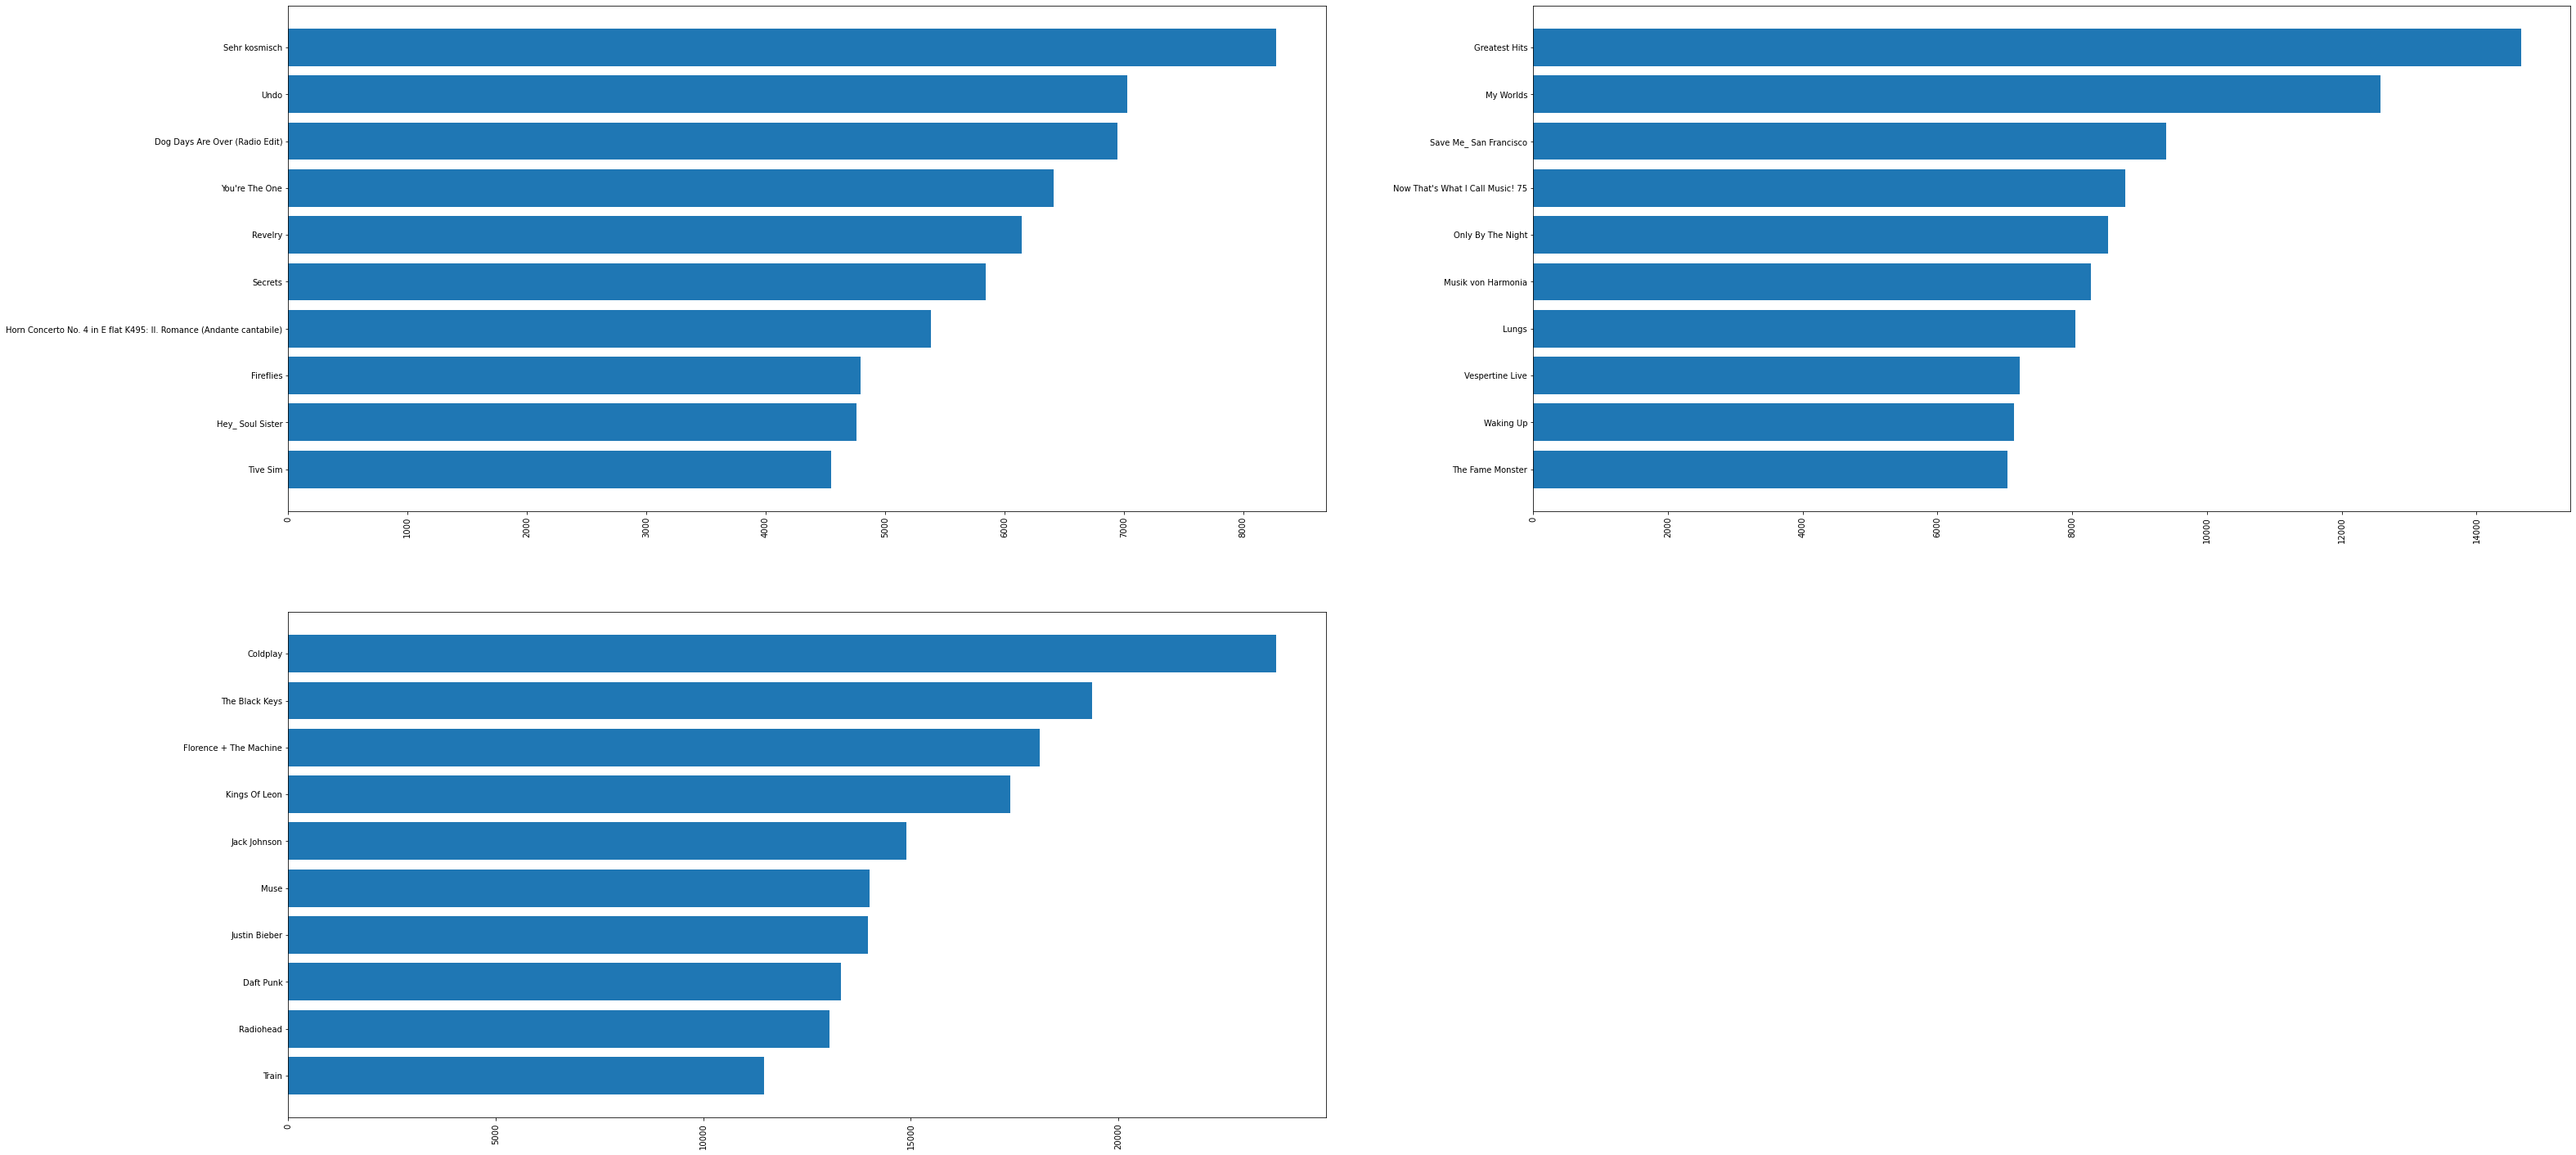

In [55]:
fig = plt.figure(figsize=(50, 25))
a1 = fig.add_subplot(221)
df_top_songs = df_top_songs.sort_values('count', ascending=False).head(10).sort_values('count')
f1 = plt.barh(df_top_songs['title'], df_top_songs['count'])
plt.xticks(rotation='vertical')

a2 = fig.add_subplot(222)
df_top_releases = df_top_releases.sort_values('count', ascending=False).head(10).sort_values('count')
f2 = plt.barh(df_top_releases['release'], df_top_releases['count'])
plt.xticks(rotation='vertical')

a3 = fig.add_subplot(223)
df_top_artists = df_top_artists.sort_values('count', ascending=False).head(10).sort_values('count')
f3 = plt.barh(df_top_artists['artist_name'], df_top_artists['count'])
plt.xticks(rotation='vertical')

plt.show()

In [56]:
print("Jumlah lagu Coldplay adalah", df_track[df_track['artist_name'] == 'Coldplay'].shape[0])

Jumlah lagu Coldplay adalah 86


* Pengguna paling banyak mendengarkan lagu yang berjudul "Sehr kosmisch" yang dinyanyikan oleh Harmonia, yaitu sebanyak 8277 pengguna. 
* Pengguna paling banyak mendengarkan lagu yang berasal dari album "Greatest Hits" yang merupakan album kompilasi dari berbagai penyanyi, yaitu sebanyak 14661 pengguna.
* Pengguna paling banyak mendengarkan lagu dari Coldplay, yaitu sebanyak 23804 pengguna, padahal lagu Coldplay tidak masuk dalam 10 lagu teratas. Hal itu mungkin terjadi karena Coldplay memiliki banyak lagu.
* 5 artis yang mempunyai lagu paling banyak dalam dataset tidak masuk dalam 10 teratas artis yang paling banyak didengarkan.

## Apa lagu, album, dan artis yang paling sering diputar pengguna?

In [57]:
df_pop_songs = df_merge.groupby(['title', 'artist_name'])['listen_count'].sum().sort_values(ascending=False).reset_index()
df_pop_songs.columns = ['title', 'artist_name', 'listen_count']
df_pop_songs.head()

,title,artist_name,listen_count
0,You're The One,Dwight Yoakam,54136
1,Undo,Björk,49253
2,Revelry,Kings Of Leon,41418
3,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,31153
4,Sehr kosmisch,Harmonia,31036


In [58]:
df_pop_releases = df_merge.groupby('release')['listen_count'].sum().sort_values(ascending=False).reset_index()
df_pop_releases.columns = ['release', 'listen_count']
df_pop_releases.head()

,release,listen_count
0,If There Was A Way,54136
1,Vespertine Live,49652
2,Only By The Night,46811
3,Greatest Hits,42795
4,My Worlds,38094


In [59]:
df_pop_artists = df_merge.groupby('artist_name')['listen_count'].sum().sort_values(ascending=False).reset_index()
df_pop_artists.columns = ['artist_name', 'listen_count']
df_pop_artists.head()

,artist_name,listen_count
0,Kings Of Leon,65961
1,Florence + The Machine,60066
2,Coldplay,55060
3,Dwight Yoakam,54136
4,Björk,52458


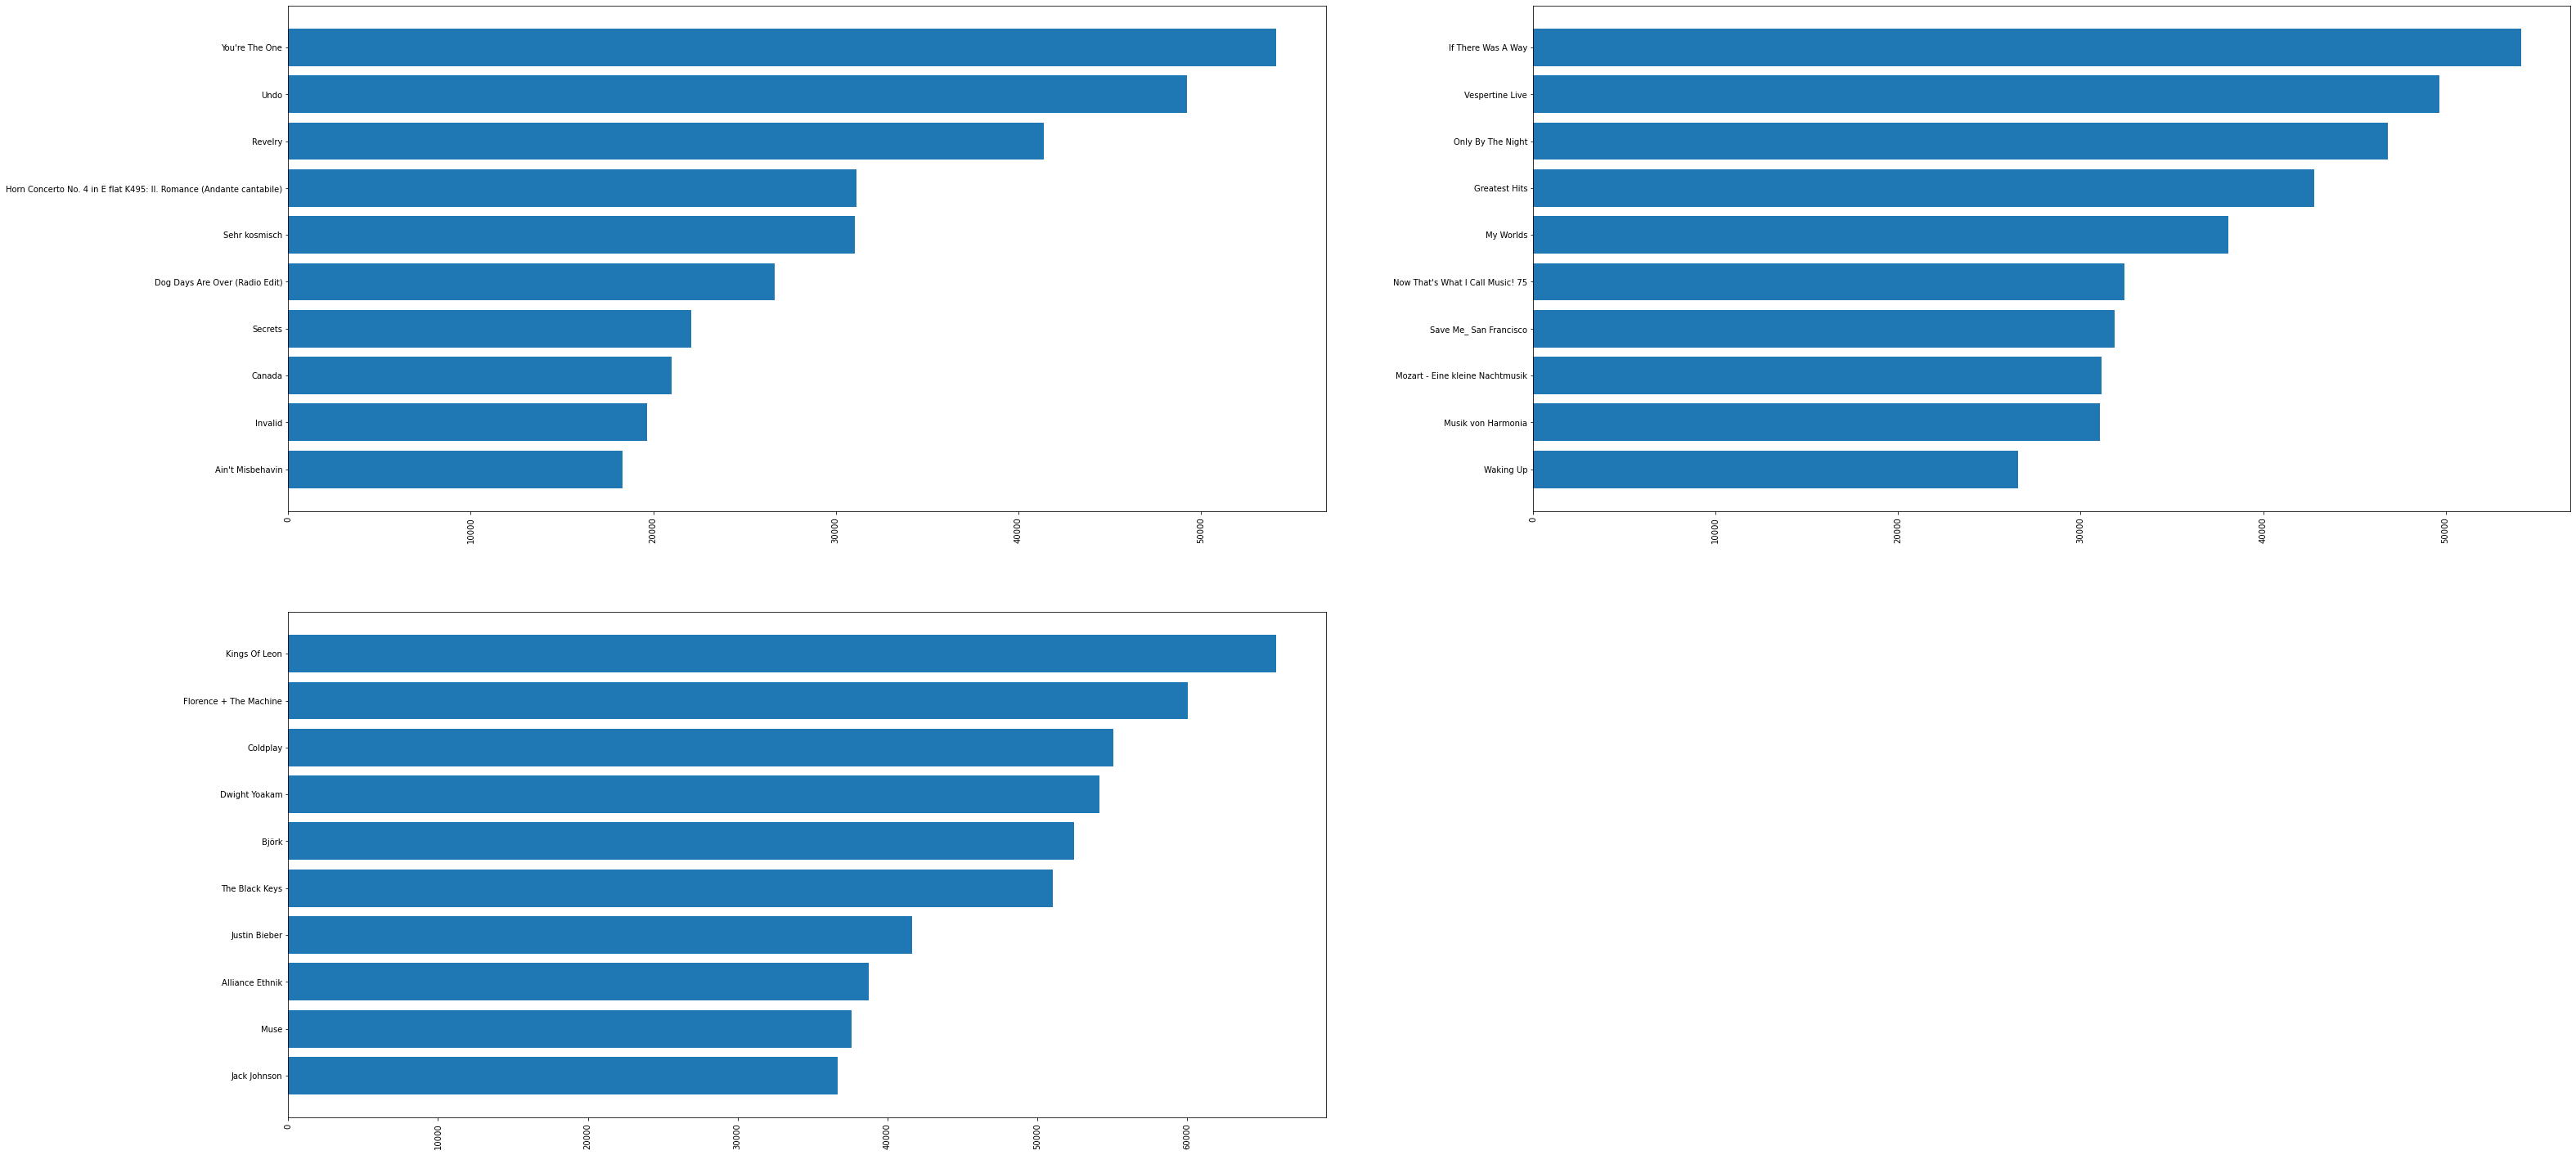

In [60]:
fig = plt.figure(figsize=(50, 25))
a1 = fig.add_subplot(221)
df_pop_songs = df_pop_songs.sort_values('listen_count', ascending=False).head(10).sort_values('listen_count')
f1 = plt.barh(df_pop_songs['title'], df_pop_songs['listen_count'])
plt.xticks(rotation='vertical')

a2 = fig.add_subplot(222)
df_pop_releases = df_pop_releases.sort_values('listen_count', ascending=False).head(10).sort_values('listen_count')
f2 = plt.barh(df_pop_releases['release'], df_pop_releases['listen_count'])
plt.xticks(rotation='vertical')

a3 = fig.add_subplot(223)
df_pop_artists = df_pop_artists.sort_values('listen_count', ascending=False).head(10).sort_values('listen_count')
f3 = plt.barh(df_pop_artists['artist_name'], df_pop_artists['listen_count'])
plt.xticks(rotation='vertical')

plt.show()

In [61]:
df_track[df_track['release'] == 'If There Was A Way']

,song_id,title,release,artist_name
218968,SOAIAOV12AC9072FC3,Since I Started Drinkin' Again,If There Was A Way,Dwight Yoakam
430091,SOBONKR12A58A7A7E0,You're The One,If There Was A Way,Dwight Yoakam


* Pengguna paling sering mendengarkan lagu yang berjudul "You're The One" yang dinyanyikan oleh Dwight Yoakam, yaitu diputar sebanyak 54136 kali. 
* Pengguna paling sering mendengarkan lagu yang berasal dari album "If There Was A Way" yang dimiliki oleh Dwight Yoakam, yaitu diputar sebanyak 54136.
* Pengguna paling sering mendengarkan lagu dari Kings Of Leon, yaitu diputar sebanyak 65961.
* 5 artis yang mempunyai lagu paling banyak dalam dataset tidak masuk dalam 10 teratas artis yang paling sering didengarkan.
* 3 lagu yang didengar oleh pendengar yang terobsesi tidak masuk dalam 10 teratas lagu yang paling sering didengarkan.
* Lagu yang paling banyak didengarkan, yaitu "Sehr kosmisch" tidak menjadi lagu yang paling sering diputar, sama halnya dengan Coldplay.

# Recommender System
Recommender System adalah sistem yang digunakan untuk menganalisis data dan membuat rekomendasi berdasarkan preferensi dan perilaku pengguna. Sistem ini melibatkan analisis data yang kompleks untuk memprediksi item yang mungkin menarik minat pengguna. Sistem rekomendasi dapat diterapkan di berbagai bidang, seperti e-commerce, hiburan, sosial media dan banyak lagi. <br/> <br/>
Algoritma yang akan digunakan:
* Collaborative Filtering
* Matrix Factorization
* Hybrid Approaches

## Collaborative Filtering
Collaborative Filtering adalah algoritma yang digunakan untuk menganalisis data dan mengidentifikasi padanan item yang mungkin disukai oleh pengguna. Algoritma ini menggunakan informasi pengguna lain untuk memprediksi apa yang dapat disukai oleh seseorang. Algoritma ini populer digunakan dalam sistem rekomendasi, di mana sistem akan mencoba untuk menemukan item yang paling sesuai dengan preferensi pengguna.

### Pivot Table

In [62]:
start_colfil = time.time()
df_colfil = df_merge.head(750000)
df_colfil = df_colfil.groupby(['title', 'release', 'artist_name', 'user_id'])['listen_count'].max().unstack()
df_colfil.head()

,,user_id,00003a4459f33b92906be11abe0e93efc423c0ff,00005c6177188f12fb5e2e82cdbd93e8a3f35e64,00030033e3a2f904a48ec1dd53019c9969b6ef1f,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,000b474f815bcff17a4bc9ce5324f9352dafe07d,000b4e4134d5f77d7608fbf86fb3e1adac4478a8,000b9a54ef0560b957ee0f7a4cb933c36025e600,000d2df2cb8ad7300f89512f8fe8fadc4f99e733,000ebc858861aca26bac9b49f650ed424cf882fc,000ef25cc955ad5841c915d269432eea41f4a1a5,...,ffec9b417b38e41a5f81c2cb763af9144f54885e,fff1d613baa7ce8e5acb7181093d9683804a55b6,fff22417a61c1ba3ee2592b22a052ed6a27a8e91,fff300cd094fe04030b79fae550dc9d065190182,fff543db7918cb8f4f56f7470903eb2f1d5a6dd8,fff6c30c773e6ffafcac213c9afd9666afaf6d63,fffad4a128cd3d130f06c0f7bf493781081afe3c,fffce9c1537fbc350ea68823d956eaa8f5236dbe,fffd6a2bdef646ce9898b628d5dd56c43df69a9d,fffe6d1d8500f1c1f31bd63abce35c0f975a86bf
title,release,artist_name,,,,,,,,,,,,,,,,,,,,,
#!*@ You Tonight [Featuring R. Kelly] (Explicit Album Version),Greatest Hits,The Notorious B.I.G.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#40,Listener Supported,DAVE MATTHEWS BAND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
& Down,Oi Oi oi REMIXED,Boys Noize,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
' Cello Song,Way To Blue - An Introduction To Nick Drake,Nick Drake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'97 Bonnie & Clyde,The Slim Shady LP,Eminem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalisasi dan Mengisi Missing Values

In [63]:
df_colfil = df_colfil.apply(lambda x: (x-np.mean(x)) / (np.max(x) - np.min(x)), axis=1)
df_colfil = df_colfil.fillna(0)
df_colfil.head()

,,user_id,00003a4459f33b92906be11abe0e93efc423c0ff,00005c6177188f12fb5e2e82cdbd93e8a3f35e64,00030033e3a2f904a48ec1dd53019c9969b6ef1f,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,000b474f815bcff17a4bc9ce5324f9352dafe07d,000b4e4134d5f77d7608fbf86fb3e1adac4478a8,000b9a54ef0560b957ee0f7a4cb933c36025e600,000d2df2cb8ad7300f89512f8fe8fadc4f99e733,000ebc858861aca26bac9b49f650ed424cf882fc,000ef25cc955ad5841c915d269432eea41f4a1a5,...,ffec9b417b38e41a5f81c2cb763af9144f54885e,fff1d613baa7ce8e5acb7181093d9683804a55b6,fff22417a61c1ba3ee2592b22a052ed6a27a8e91,fff300cd094fe04030b79fae550dc9d065190182,fff543db7918cb8f4f56f7470903eb2f1d5a6dd8,fff6c30c773e6ffafcac213c9afd9666afaf6d63,fffad4a128cd3d130f06c0f7bf493781081afe3c,fffce9c1537fbc350ea68823d956eaa8f5236dbe,fffd6a2bdef646ce9898b628d5dd56c43df69a9d,fffe6d1d8500f1c1f31bd63abce35c0f975a86bf
title,release,artist_name,,,,,,,,,,,,,,,,,,,,,
#!*@ You Tonight [Featuring R. Kelly] (Explicit Album Version),Greatest Hits,The Notorious B.I.G.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#40,Listener Supported,DAVE MATTHEWS BAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
& Down,Oi Oi oi REMIXED,Boys Noize,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
' Cello Song,Way To Blue - An Introduction To Nick Drake,Nick Drake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'97 Bonnie & Clyde,The Slim Shady LP,Eminem,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Matrix CSR

In [64]:
df_colfil_sparse = sp.sparse.csr_matrix(df_colfil.values)
df_colfil_sparse

<8841x33521 sparse matrix of type '<class 'numpy.float64'>'
	with 748992 stored elements in Compressed Sparse Row format>

In [65]:
df_colfil_sparse = df_colfil_sparse.astype(np.float16)
df_colfil_sparse

<8841x33521 sparse matrix of type '<class 'numpy.float16'>'
	with 748992 stored elements in Compressed Sparse Row format>

### Cosine Similarity

In [66]:
item_similarity = cosine_similarity(df_colfil_sparse)
item_similarity

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.00111696, ...,  0.00247403,
         0.        ,  0.00306534],
       [ 0.        ,  0.00111696,  1.        , ...,  0.        ,
         0.        ,  0.00124162],
       ...,
       [ 0.        ,  0.00247403,  0.        , ...,  1.        ,
        -0.00838297,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.00838297,
         1.        ,  0.        ],
       [ 0.        ,  0.00306534,  0.00124162, ...,  0.        ,
         0.        ,  1.        ]])

In [67]:
user_similarity = cosine_similarity(df_colfil_sparse.T)
user_similarity

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        2.69153258e-03, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 2.69153258e-03, ...,
        1.00000000e+00, 0.00000000e+00, 6.48054110e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.48054110e-04, 0.00000000e+00, 1.00000000e+00]])

### Convert ke Dataframe

In [68]:
df_item_sim = pd.DataFrame(item_similarity, index = df_colfil.index, columns = df_colfil.index)
df_item_sim.head()

title                                                                                                               #!*@ You Tonight [Featuring R. Kelly] (Explicit Album Version)  \
release                                                                                                                                                              Greatest Hits   
artist_name                                                                                                                                                   The Notorious B.I.G.   
title                                              release                                     artist_name                                                                           
#!*@ You Tonight [Featuring R. Kelly] (Explicit... Greatest Hits                               The Notorious B.I.G.                                                1.0               
#40                                                Listener Supported                          DAVE MATTHEWS BAND                                                  0.0               
& Down                                             Oi Oi oi REMIXED                            Boys Noize                                                          0.0               
' Cello Song                                       Way To Blue - An Introduction To Nick Drake Nick Drake                                                          0.0               
'97 Bonnie & Clyde                                 The Slim Shady LP                           Eminem                                                              0.0               

title                                                                                                                              #40  \
release                                                                                                             Listener Supported   
artist_name                                                                                                         DAVE MATTHEWS BAND   
title                                              release                                     artist_name                               
#!*@ You Tonight [Featuring R. Kelly] (Explicit... Greatest Hits                               The Notorious B.I.G.           0.000000   
#40                                                Listener Supported                          DAVE MATTHEWS BAND             1.000000   
& Down                                             Oi Oi oi REMIXED                            Boys Noize                     0.001117   
' Cello Song                                       Way To Blue - An Introduction To Nick Drake Nick Drake                    -0.005358   
'97 Bonnie & Clyde                                 The Slim Shady LP                           Eminem                         0.000000   

title                                                                                                                         & Down  \
release                                                                                                             Oi Oi oi REMIXED   
artist_name                                                                                                               Boys Noize   
title                                              release                                     artist_name                             
#!*@ You Tonight [Featuring R. Kelly] (Explicit... Greatest Hits                               The Notorious B.I.G.         0.000000   
#40                                                Listener Supported                          DAVE MATTHEWS BAND           0.001117   
& Down                                             Oi Oi oi REMIXED                            Boys Noize                   1.000000   
' Cello Song                                       Way To Blue - An Introduction To Nick Drake Nick Drake                   0.000000   
'97 Bonnie & Clyde            

In [69]:
df_user_sim = pd.DataFrame(user_similarity, index = df_colfil.columns, columns = df_colfil.columns)
df_user_sim.head()

user_id,00003a4459f33b92906be11abe0e93efc423c0ff,00005c6177188f12fb5e2e82cdbd93e8a3f35e64,00030033e3a2f904a48ec1dd53019c9969b6ef1f,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,000b474f815bcff17a4bc9ce5324f9352dafe07d,000b4e4134d5f77d7608fbf86fb3e1adac4478a8,000b9a54ef0560b957ee0f7a4cb933c36025e600,000d2df2cb8ad7300f89512f8fe8fadc4f99e733,000ebc858861aca26bac9b49f650ed424cf882fc,000ef25cc955ad5841c915d269432eea41f4a1a5,...,ffec9b417b38e41a5f81c2cb763af9144f54885e,fff1d613baa7ce8e5acb7181093d9683804a55b6,fff22417a61c1ba3ee2592b22a052ed6a27a8e91,fff300cd094fe04030b79fae550dc9d065190182,fff543db7918cb8f4f56f7470903eb2f1d5a6dd8,fff6c30c773e6ffafcac213c9afd9666afaf6d63,fffad4a128cd3d130f06c0f7bf493781081afe3c,fffce9c1537fbc350ea68823d956eaa8f5236dbe,fffd6a2bdef646ce9898b628d5dd56c43df69a9d,fffe6d1d8500f1c1f31bd63abce35c0f975a86bf
user_id,,,,,,,,,,,,,,,,,,,,,
00003a4459f33b92906be11abe0e93efc423c0ff,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.040008,0.0,0.000000,0.0,0.0
00005c6177188f12fb5e2e82cdbd93e8a3f35e64,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.012618,0.0,0.000000,0.0,0.0
00030033e3a2f904a48ec1dd53019c9969b6ef1f,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,-0.012507,0.0,0.0,0.000000,0.0,0.002692,0.0,0.0
0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.044627,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
000b474f815bcff17a4bc9ce5324f9352dafe07d,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.007132,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


### Fungsi Rekomendasi

In [70]:
def rec_colfil(user, rec):
    sim_users = df_user_sim.sort_values(by=user, ascending=False).index[1:11]
    best = []
    most_common = {}
    
    for i in sim_users:
        max_score = df_colfil.loc[:, i].max()
        best.append(df_colfil[df_colfil.loc[:, i]==max_score].index.tolist())
    for i in range(len(best)):
        for j in best[i]:
            if j in most_common:
                most_common[j] += 1
            else:
                most_common[j] = 1
                
    sorted_list = sorted(most_common.items(), key=operator.itemgetter(1), reverse=True)
    
    list_rank = [*range(1, rec+1, 1)]
    list_title = []
    list_artist = []
    df_rec_colfil = pd.DataFrame(list_rank)
    for i in range(0, rec+1, 1):
        key = list(dict(most_common.items()).keys())[i]
        list_title.append(key[0])
        list_artist.append(key[2])
    
    df_rec_colfil['title'] = pd.DataFrame(list_title)
    df_rec_colfil['artist_name'] = pd.DataFrame(list_artist)
    df_rec_colfil.columns = ['rank', 'title', 'artist_name']
    return df_rec_colfil  

### Hasil Rekomendasi

In [71]:
rec_colfil('b80344d063b5ccb3212f76538f3d9e43d87dca9e', 10)

,rank,title,artist_name
0,1,#!*@ You Tonight [Featuring R. Kelly] (Explici...,The Notorious B.I.G.
1,2,#40,DAVE MATTHEWS BAND
2,3,& Down,Boys Noize
3,4,' Cello Song,Nick Drake
4,5,'97 Bonnie & Clyde,Eminem
5,6,'Round Midnight,Miles Davis
6,7,'Round Midnight,Amy Winehouse
7,8,'Til We Die (Album Version),Slipknot
8,9,'Till I Collapse,Eminem / Nate Dogg
9,10,('Til) I Kissed You,Everly Brothers


In [72]:
end_colfil = time.time()

In [73]:
rec_colfil('85c1f87fea955d09b4bec2e36aee110927aedf9a', 5)

,rank,title,artist_name
0,1,The Best of Times,Sage Francis
1,2,You Are the Moon (Album Version),The Hush Sound
2,3,Music Box,The Cinematic Orchestra feat. Lou Rhodes
3,4,Full Clip (Explicit),Gang Starr
4,5,Raid,Madvillain_ MED aka Medaphor


## Matrix Factorization
Matrix Factorization adalah algoritma yang digunakan untuk mengekstrak informasi dari matriks data yang terdiri dari berbagai item. Algoritma ini menggunakan matriks faktorisasi untuk menguraikan matriks data menjadi dua buah matriks yang lebih kecil dan lebih mudah diproses. Matriks faktorisasi digunakan untuk mengekstrak fitur yang relevan yang dapat digunakan untuk menghasilkan prediksi yang akurat dengan menggunakan matriks data.

### Fungsi untuk Rekomendasi

In [74]:
start_matfac = time.time()
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)
    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i, i] = mt.sqrt(s[i])
        U = csc_matrix(U, dtype=np.float32)
        S = csc_matrix(S, dtype=np.float32)
        Vt = csc_matrix(Vt, dtype=np.float32)
        return U, S, Vt

In [75]:
def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S * Vt 
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recommendRatings = np.zeros(shape=(MAX_UID, max_recommendation), dtype=np.float16)
    prod = U[uTest, :] * rightTerm
    estimatedRatings[uTest, :] = prod.todense()
    recommendRatings[uTest, :] = (-estimatedRatings[uTest, :]).argsort()[:max_recommendation]
    return recommendRatings

In [76]:
def rec_matfac(uTest, num_recomendations = 10):
    rank_value = 1
    i = 0
    list_rank = [*range(1, 11, 1)]
    df_rec_matfac = pd.DataFrame(list_rank)
    while (rank_value < num_recomendations + 1):
        so = uTest_recommended_items[uTest, i:i+1][0]
        if (small_set['user_id'][(small_set['song_index_value'] == so) & (small_set['user_index_value'] == uTest)].count() == 0):
            song_details = small_set[(small_set['song_index_value'] == so)].drop_duplicates('song_index_value')[['title', 'artist_name']]
            df_rec_matfac.loc[i, 'title'] = list(song_details['title'])[0]
            df_rec_matfac.loc[i, 'artist_name'] = list(song_details['artist_name'])[0]
            rank_value += 1
        i += 1
    df_rec_matfac.columns = ['rank', 'title', 'artist_name']
    return df_rec_matfac

### Fractional Play Count

In [77]:
df_matfac = df_merge[['user_id', 'listen_count']].groupby('user_id').sum().reset_index()
df_matfac.rename(columns={'listen_count':'total_listen_count'}, inplace=True)
df_matfac_merge = pd.merge(df_merge, df_matfac)
df_matfac_merge['fractional_play_count'] = df_matfac_merge['listen_count'] / df_matfac_merge['total_listen_count']

display(df_matfac_merge[df_matfac_merge['user_id'] == 'b80344d063b5ccb3212f76538f3d9e43d87dca9e'][['user_id', 'title', 'artist_name', 'listen_count',
                                                                                                   'total_listen_count', 'fractional_play_count']].head())

,user_id,title,artist_name,listen_count,total_listen_count,fractional_play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,The Cove,Jack Johnson,1,64,0.015625
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Entre Dos Aguas,Paco De Lucia,2,64,0.031250
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Constellations,Jack Johnson,1,64,0.015625
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Learn To Fly,Foo Fighters,1,64,0.015625
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Apuesta Por El Rock 'N' Roll,Héroes del Silencio,5,64,0.078125


### Matrix CSR dan Konversi user_id

In [78]:
user_codes = df_matfac_merge['user_id'].drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'}, inplace=True)
user_codes['user_index_value'] = list(user_codes.index)

song_codes = df_matfac_merge['song_id'].drop_duplicates().reset_index()
song_codes.rename(columns={'index':'song_index'}, inplace=True)
song_codes['song_index_value'] = list(song_codes.index)

small_set = pd.merge(df_matfac_merge, song_codes, how='left')
small_set = pd.merge(small_set, user_codes, how='left')
mat_candidate = small_set[['user_index_value', 'song_index_value', 'fractional_play_count']]

data_array = mat_candidate['fractional_play_count'].values
row_array = mat_candidate['user_index_value'].values
col_array = mat_candidate['song_index_value'].values

data_sparse = coo_matrix((data_array, (row_array, col_array)), dtype=float)

display(data_sparse)
user_codes.head()

<76176x8841 sparse matrix of type '<class 'numpy.float64'>'
	with 1718983 stored elements in COOrdinate format>

,user_index,user_id,user_index_value
0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,0
1,38,85c1f87fea955d09b4bec2e36aee110927aedf9a,1
2,39,bd4c6e843f00bd476847fb75c47b4fb430a06856,2
3,46,8937134734f869debcab8f23d77465b4caaa85df,3
4,48,969cc6fb74e076a68e36a04409cb9d3765757508,4


### Menghitung SVD

In [79]:
K = 50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]
U, S, Vt = compute_svd(urm, K)

### Hasil Rekomendasi

In [80]:
uTest = 0
uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)
rec_matfac(uTest)

,rank,title,artist_name
0,1,Just Dance,Lady GaGa / Colby O'Donis
1,2,The Maestro,Beastie Boys
2,3,Use Somebody,Kings Of Leon
3,4,Sugar Ray (LP Version),Todd Barry
4,5,Bulletproof,La Roux
5,6,Better To Reign In Hell,Cradle Of Filth
6,7,It Was A Good Day,Ice Cube
7,8,Musti Sotakoira (2007 Digital Remaster),Kollaa Kestää
8,9,Sexy Bitch,DJ Dizzy
9,10,Sample Track 2,Simon Harris


In [81]:
end_matfac = time.time()

In [82]:
uTest = 1
uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)
rec_matfac(uTest)

,rank,title,artist_name
0,1,Obsesion,Aventura
1,2,Interactive Halloween Bear,Restiform Bodies
2,3,Alejandro,Lady GaGa
3,4,Reign Of The Tyrants,Jag Panzer
4,5,You Don't Know Me (Album Version),Michael Bublé
5,6,Day 'N' Nite,Kid Cudi Vs Crookers
6,7,I CAN'T GET STARTED,Ron Carter
7,8,Nah!,Shania Twain
8,9,Pursuit Of Happiness (nightmare),Kid Cudi / MGMT / Ratatat
9,10,Teach Me How To Dougie,California Swag District


## Hybrid Approaches

Hybrid Approaches adalah algoritma yang menggabungkan teknik pembelajaran mesin dan teknik pembelajaran bertingkat untuk menangani masalah rekomendasi. Algoritma ini menggunakan kedua pendekatan untuk membuat rekomendasi yang akurat, dengan mempertimbangkan faktor-faktor seperti item, pengguna, dan data konteks. 

### Item Dictionary. One Hot Encoding Item, dan Matrix CSR

In [83]:
start_hybrid = time.time()
item_dict ={}
df_songs_hybrid = df_merge[['song_id', 'title', 'artist_name']].drop_duplicates().sort_values('song_id').reset_index()
for i in range(df_songs_hybrid.shape[0]):
    item_dict[(df_songs_hybrid.loc[i, 'song_id'])] = [df_songs_hybrid.loc[i, 'title'], df_songs_hybrid.loc[i, 'artist_name']]

df_songs_hybrid_selected = df_merge[['song_id', 'title', 'release', 'artist_name']].drop_duplicates()
df_songs_hybrid_selected = pd.get_dummies(df_songs_hybrid_selected, columns = ['release', 'artist_name'], sparse=True)
df_songs_hybrid_selected = df_songs_hybrid_selected.sort_values('song_id').reset_index().drop('index', axis=1)

df_songs_hybrid_sparse = csr_matrix(df_songs_hybrid_selected.drop(['song_id', 'title'], axis=1).values)
display(df_songs_hybrid_sparse)
display(df_songs_hybrid_selected)

<8841x7849 sparse matrix of type '<class 'numpy.intc'>'
	with 17682 stored elements in Compressed Sparse Row format>

,song_id,title,release_#1,release_#1's,release_#1s ... and then some,release_'70s Pop #1's,release_'80s Soul #1's,release_'90s Soul Number 1's,release_'Round Midnight - Original Motion Picture Soundtrack,release_(A)fternoon,...,artist_name_dEUS,artist_name_harvey summers,artist_name_iio,artist_name_keller williams,artist_name_matchbox twenty,artist_name_moe.,artist_name_rinôçérôse,artist_name_the bird and the bee,artist_name_themselves,artist_name_tobyMac
0,SOAAAGQ12A8C1420C8,Orgelblut,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,SOAACPJ12A81C21360,Cearc Agus Coileach / The Hen And Cock,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,SOAACSG12AB018DC80,I Gotta Feeling (Edit),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,SOAAEJI12AB0188AB5,Godlovesugly,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SOAAFAC12A67ADF7EB,Rome Wasn't Built In A Day,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8836,SOZZTCU12AB0182C58,Throw Some D's Remix,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8837,SOZZTNF12A8C139916,Le Million,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8838,SOZZVWB12AB0189C30,Recovered,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8839,SOZZYAO12A6701FF36,Sunset (Bird Of Prey),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Pivot Table User dan Matrix CSR

In [84]:
df_users_hybrid = pd.pivot_table(df_merge, index='user_id', columns='song_id', values='listen_count')

df_users_hybrid = df_users_hybrid.fillna(0)
user_id = list(df_users_hybrid.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

df_users_hybrid_sparse = csr_matrix(df_users_hybrid.values)
display(df_users_hybrid_sparse)
display(df_users_hybrid)

<76176x8841 sparse matrix of type '<class 'numpy.float64'>'
	with 1718983 stored elements in Compressed Sparse Row format>

song_id,SOAAAGQ12A8C1420C8,SOAACPJ12A81C21360,SOAACSG12AB018DC80,SOAAEJI12AB0188AB5,SOAAFAC12A67ADF7EB,SOAAFYH12A8C13717A,SOAAJMQ12A6D4F7D17,SOAAKPM12A58A77210,SOAALWN12A6D4F7FDA,SOAAMOW12AB018149B,...,SOZZIOH12A67ADE300,SOZZKPR12A6D4F8147,SOZZLTY12A67AE0AD0,SOZZLZN12A8AE48D6D,SOZZRHE12A6702165F,SOZZTCU12AB0182C58,SOZZTNF12A8C139916,SOZZVWB12AB0189C30,SOZZYAO12A6701FF36,SOZZZPV12A8C1444B5
user_id,,,,,,,,,,,,,,,,,,,,,
00003a4459f33b92906be11abe0e93efc423c0ff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00005c6177188f12fb5e2e82cdbd93e8a3f35e64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00030033e3a2f904a48ec1dd53019c9969b6ef1f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0007235c769e610e3d339a17818a5708e41008d9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffce9c1537fbc350ea68823d956eaa8f5236dbe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fffd6a2bdef646ce9898b628d5dd56c43df69a9d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fffd9635b33f412de8ed02e44e6564e3644cf3c6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Convert Tipe

In [85]:
df_users_hybrid_sparse = df_users_hybrid_sparse.astype(np.float16)
df_users_hybrid_sparse

<76176x8841 sparse matrix of type '<class 'numpy.float16'>'
	with 1718983 stored elements in Compressed Sparse Row format>

### Fit Model dengan LightFM

In [86]:
model = LightFM(loss='warp',
                random_state=2000,
                learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005)
model = model.fit(df_users_hybrid_sparse,
                  epochs=5,
                  num_threads=16, verbose=False)

### Fungsi Rekomendasi

In [87]:
df_listen_count = df_merge[['user_id', 'song_id', 'listen_count']]

In [88]:
def rec_hybrid(df_listen_count, user_id, threshold = 0, nrec_items = 10, show = True):
    
    n_users, n_items = df_listen_count.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=df_songs_hybrid_sparse))
    scores.index = df_listen_count.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(df_listen_count.loc[user_id,:][df_listen_count.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    
    list_rank = [*range(1, 11, 1)]
    df_rec_hybrid = pd.DataFrame(list_rank)
    list_title = []
    list_artist = []
    counter = 1
    for i in scores:
        list_title.append(i[0])
        list_artist.append(i[1])
        counter += 1
    df_rec_hybrid['title'] = list_title
    df_rec_hybrid['artist_name'] = list_artist
    df_rec_hybrid.columns = ['rank', 'title', 'artist_name']
    return df_rec_hybrid

### Hasil Rekomendasi

In [89]:
rec_hybrid(df_users_hybrid, 'b80344d063b5ccb3212f76538f3d9e43d87dca9e')

,rank,title,artist_name
0,1,Swing Life Away (Acoustic),Rise Against
1,2,I Wish You Would,The Yardbirds
2,3,Heart Of A Champion,Nelly / Lincoln University Vocal Ensemble
3,4,Ticket To Heaven,3 Doors Down
4,5,The Road I'm On,3 Doors Down
5,6,La Rivalita (Album Version),The Audition
6,7,Slow Death,Flamin' Groovies
7,8,Nine Steps,Decapitated
8,9,Pork And Beans,Weezer
9,10,Hand On Your Heart,José González


In [90]:
end_hybrid = time.time()

In [91]:
rec_hybrid(df_users_hybrid, '85c1f87fea955d09b4bec2e36aee110927aedf9a')

,rank,title,artist_name
0,1,Swing Life Away (Acoustic),Rise Against
1,2,Hoy Te Deje De Amar (copia),Paulina Rubio
2,3,I Wish You Would,The Yardbirds
3,4,La Rivalita (Album Version),The Audition
4,5,Slow Death,Flamin' Groovies
5,6,Heart Of A Champion,Nelly / Lincoln University Vocal Ensemble
6,7,Teach Me Tiger,April Stevens
7,8,Hand On Your Heart,José González
8,9,Falsa Baiana,João Gilberto
9,10,Eu Quero Um Samba,João Gilberto


# Evaluation
Evaluation dalam data science adalah proses mengevaluasi hasil dari seluruh tahap yang telah dilakukan sebelumnya. Proses ini mencakup mengukur akurasi dari model yang telah dibuat dan mengevaluasi kinerja model. Proses ini juga bertujuan untuk mengidentifikasi kemungkinan kegagalan atau masalah yang mungkin terjadi dan mengidentifikasi cara yang lebih baik untuk meningkatkan model.

## Berdasarkan Waktu

In [92]:
list_model = ["Collaborative Filtering", "Matrix Factorization", "Hybrid Approaches"]
df_exec = pd.DataFrame(list_model)
list_time = [end_colfil - start_colfil, end_matfac - start_matfac, end_hybrid - start_hybrid]
df_exec['time'] = pd.DataFrame(list_time)
df_exec.columns = ['algorithm', 'time']
df_exec = df_exec.sort_values('time', ascending=True)
df_exec

,algorithm,time
1,Matrix Factorization,8.502695
0,Collaborative Filtering,107.386683
2,Hybrid Approaches,479.611835


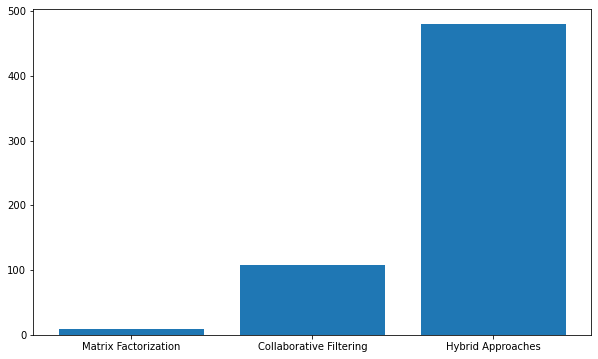

In [93]:
plt.figure(figsize = (10,6))
plt.bar(df_exec['algorithm'], df_exec['time'])
plt.show()

* Berdasarkan hasilnya, masing-masing dari ketiga algoritma tersebut menghasilkan rekomendasi yang berbeda-beda.
* Berdasarkan waktu eksekusinya, algoritma Matrix Factorization adalah algoritma yang paling cepat dijalankan, disusul dengan algoritma Collaborative Filtering dan Hybrid Approaches.

# Conclusion
Recommender system yang didasarkan pada preferensi pengguna telah dibuat dengan menggunakan 3 algoritma, yaitu Collaborative Filtering, Matrix Factorization, dan Hybrid Approaches. Dari ketiga algoritma tersebut, algoritma Matrix Factorization paling tepat diterapkan karena waktu eksekusinya yang paling cepat dan minim error.